## 이미지  데이터  탐색적 데이터  분석
### 1. 82 개 요가 이미지 데이터셋 EDA
출처:
1. Yoga-82: A New Dataset for Fine-grained Classification of Human Poses [arXiv](https://arxiv.org/abs/2004.10362)
2. [Yoga Pose Image classification dataset](https://www.kaggle.com/shrutisaxena/yoga-pose-image-classification-dataset)

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
from urllib import request
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def yoga82txt_to_df(path='/content/drive/MyDrive/wellai/yoga_82/'):
  '''Yoga-82의 텍스트 파일 기반으로 데이터 프레임 생성'''
  files1 = glob(path+'yoga_train.txt')
  files2 = glob(path+'yoga_test.txt')

  for f in files1:
    train = pd.read_csv(f,header=None)
    train[['Folder','File']]=train[0].str.split('/', expand=True)

  for f in files2:
    test = pd.read_csv(f,header=None)
    test[['Folder','File']]=test[0].str.split('/', expand=True)

  total_df = pd.concat([train, test])
  total_df=total_df.rename(columns={1:'6poses',2:'20poses',3:'82poses'})
  return total_df[['Folder','File','6poses','20poses','82poses']]



In [71]:
def directory_to_df(path):
  '''파일 디렉토리를 데이터프레임으로 변환합니다. '''
  data = []
  for folder in sorted(os.listdir(path)[:81]):
      for file in sorted(os.listdir(path+'/'+folder)):
          data.append((folder, file))
  df = pd.DataFrame(data, columns=['Folder', 'Img'])
  return df

In [ ]:
def mapping_82poses():
  ''' 디렉토리 이름 기준으로 클래스 추출하여 딕셔너리로 반환합니다.'''
  groupby82= yoga82txt_to_df().groupby('Folder').count()
  mapping82={}
  for i in range(len(groupby82.index)):
    mapping82[i]=groupby82.index[i]
  return mapping82
  
mapping_82poses()

{0: 'Akarna_Dhanurasana',
 1: "Bharadvaja's_Twist_pose_or_Bharadvajasana_I_",
 2: 'Boat_Pose_or_Paripurna_Navasana_',
 3: 'Bound_Angle_Pose_or_Baddha_Konasana_',
 4: 'Bow_Pose_or_Dhanurasana_',
 5: 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_',
 6: 'Camel_Pose_or_Ustrasana_',
 7: 'Cat_Cow_Pose_or_Marjaryasana_',
 8: 'Chair_Pose_or_Utkatasana_',
 9: 'Child_Pose_or_Balasana_',
 10: 'Cobra_Pose_or_Bhujangasana_',
 11: 'Cockerel_Pose',
 12: 'Corpse_Pose_or_Savasana_',
 13: 'Cow_Face_Pose_or_Gomukhasana_',
 14: 'Crane_(Crow)_Pose_or_Bakasana_',
 15: 'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_',
 16: 'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_',
 17: 'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_',
 18: 'Eagle_Pose_or_Garudasana_',
 19: 'Eight-Angle_Pose_or_Astavakrasana_',
 20: 'Extended_Puppy_Pose_or_Uttana_Shishosana_',
 21: 'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_',
 22: 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_',
 23: 'Feathered_Peacock_Pose_or

### 2. Yoga-82 데이터셋과 캐글 데이터셋 병합본 전처리
- 해당 Yoga-82에서 제공하는 링크를 통해서 받은 이미지 중에서 사용 불가능한 경우가 많아져서 다른 데이터셋으로 보충하였다. 보충하였음에도 pose estimator모델에서도 threshold에 따라 인식 안되는 그림 이미지나 앵글에 따른 사진을 약 5800장 제외했는데 원래 데이터셋 +추가 데이터에 배해서 약 1만 9천장이 사라짐.


In [22]:
yoga82_dataset=yoga82txt_to_df()
real_files=directory_to_df('/content/drive/MyDrive/wellai/Images')
processed_fiels=directory_to_df('/content/drive/MyDrive/ai_trainer/images_v2')
kp_processed_files=directory_to_df('/content/drive/MyDrive/ai_trainer/kp_processed')

In [75]:
print(f'Yoga-82(논문 기준) : {yoga82_dataset.shape[0]}장 ')
print(f'Yoga-82 & kaggle yoga images(valid): {real_files.shape[0]}장 ')
print(f'pose estimator 전처리 이후 : {kp_processed_files.shape[0]}장')

Yoga-82(논문 기준) : 28450장 
Yoga-82 & kaggle yoga images(valid): 21268장 
pose estimator 전처리 이후 : 15716장


In [76]:
print( 'pose estimator 전처리 이후 사라진 전체 데이터 양: ',kp_processed_files.shape[0] - yoga82_dataset.shape[0]-5994)
print( '전처리 후 사라진 데이터 양: ',kp_processed_files.shape[0] - real_files.shape[0])

pose estimator 전처리 이후 사라진 전체 데이터 양:  -18728
전처리 후 사라진 데이터 양:  -5552


In [82]:
def preprocessing_directory(df):
  '''yoga-82에서 제공한 각 폴더별 계층적 포즈를 입력한 데이터프레임과 동일한 폴더명을 갖는 경우 매핑'''
  yoga82_dataset=yoga82txt_to_df()
  df['6poses']=df.Folder.map(yoga82_dataset.set_index('Folder')['6poses'].to_dict())
  df['20poses']=df.Folder.map(yoga82_dataset.set_index('Folder')['20poses'].to_dict())
  df['82poses']=df.Folder.map(yoga82_dataset.set_index('Folder')['82poses'].to_dict())
  
  return df
  
preprocessing_directory(kp_processed_files)#real_files.to_csv('') 


,Folder,Img,6poses,20poses,82poses,6 poses
0,Akarna_Dhanurasana,0_350.jpg,1.0,8.0,0.0,앉아서
1,Akarna_Dhanurasana,0_377.jpg,1.0,8.0,0.0,앉아서
2,Akarna_Dhanurasana,1.jpg,1.0,8.0,0.0,앉아서
3,Akarna_Dhanurasana,10.jpg,1.0,8.0,0.0,앉아서
4,Akarna_Dhanurasana,106.jpg,1.0,8.0,0.0,앉아서
...,...,...,...,...,...,...
15711,Yogic_sleep_pose,1_124.jpg,4.0,13.0,80.0,누워서
15712,Yogic_sleep_pose,1_20.jpg,4.0,13.0,80.0,누워서
15713,Yogic_sleep_pose,2_1.jpg,4.0,13.0,80.0,누워서
15714,Yogic_sleep_pose,3-0.jpg,4.0,13.0,80.0,누워서


In [83]:
mapper6={0:'서서하기',1:'앉아서',2:'밸런스',3:'팔',4:'누워서',5:'코어'}

kp_processed_files['6 poses'] = kp_processed_files['6poses'].map(mapper6)
kp_processed_files.groupby(by=['Folder','6 poses']).count().reset_index(inplace=True)

In [84]:
#82-6포즈로 값 확인용 예. [('Akarna_Dhanurasana', 'Sitting'), ...]
data=kp_processed_files.groupby(['Folder','6 poses']).count().index.values
import csv

with open("/content/drive/MyDrive/wellai/mapping.csv", "w") as f:
    csv_writer = csv.writer(f)
    for mytuple in data:
        csv_writer.writerow(mytuple)

##### 1. 분포
- 6, 20, 82 포즈 별 분포 확인
- 각 카테고리별 차이 큼
  - 82가지 포즈들은 좌측에 쏠려있고 그나마 뾰족한 정규분포에 가까움(양의 첨도)
  - 6,20가지 포즈들은 분포가 넓음
  - 특정 포즈에 카테고리/포즈에 이미지가 많음


Text(0.5, 1.0, '82 poses')

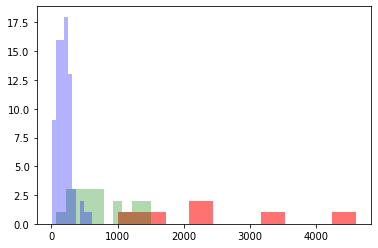

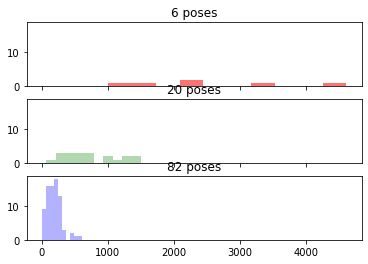

In [85]:
plt.hist(kp_processed_files.groupby('6poses')[['Folder']].count().values.flatten(), color ='#ff7272')
plt.hist(kp_processed_files.groupby('20poses')[['Folder']].count().values.flatten(),color='green',alpha=0.3)
plt.hist(kp_processed_files.groupby('82poses')[['Folder']].count().values.flatten(),color='blue',alpha=0.3)

fig, ax = plt.subplots(3,1, sharex='col', sharey='col')
ax[0].hist(kp_processed_files.groupby('6poses')[['Folder']].count().values.flatten(), color ='#ff7272')
ax[1].hist(kp_processed_files.groupby('20poses')[['Folder']].count().values.flatten(),color='green',alpha=0.3)
ax[2].hist(kp_processed_files.groupby('82poses')[['Folder']].count().values.flatten(),color='blue',alpha=0.3)


ax[0].set_title("6 poses")
ax[1].set_title("20 poses")
ax[2].set_title("82 poses")

##### 2. 빈도수
- 클래스별 빈도수를 기반으로 이후에 불균형 데이터셋 리샘플링을 위한 처리에 참고할 예정
- 위의 분포를 보고 예측한거와 같이 특정 클래스에 쏠려 있음. 특정 최상위 자세들에 클래스가 많을거라고 예상되며 특정 자세들에 더 많은 이미지들이 포함된 것으로 확인됨

In [86]:
kp_processed_files.groupby(['6 poses']).count()[['Img']] #최대 4배

,Img
6 poses,
누워서,3312
밸런스,1006
서서하기,4609
앉아서,2264
코어,2267
팔,1454


- 최대 200배 차이

In [87]:
kp_processed_files.groupby(['20poses']).count()[['Img']] #최대 20배 이상 차이

,Img
20poses,
0.0,727
1.0,1030
2.0,1505
3.0,1347
4.0,559
5.0,749
6.0,71
7.0,528
8.0,357


 - 특정 클래스에 이미지가 더 많거나 적어서  undersampling, oversampling동시 진행 예정
- 최대 갯수와 최소 갯수 차이가 10배 
- 모델 결과를 보고 metrics 를 복합적으로 고려해서 결정

<Figure size 1440x1080 with 0 Axes>

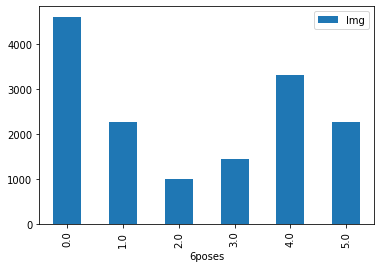

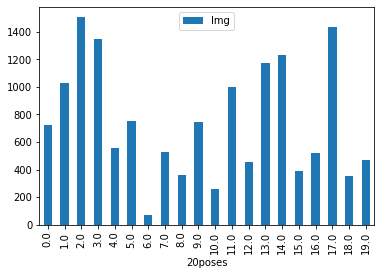

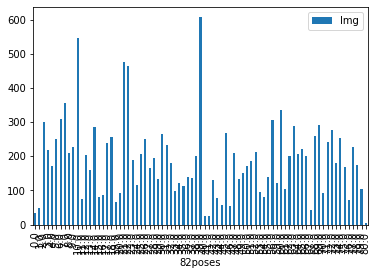

In [88]:
plt.figure(figsize=(20,15))
group_6=kp_processed_files.groupby(['6poses']).count()[['Img']].plot(kind='bar')
group_20=kp_processed_files.groupby(['20poses']).count()[['Img']].plot(kind='bar')
group_82=kp_processed_files.groupby(['82poses']).count()[['Img']].plot(kind='bar')


y축 중앙값 정도로 확대해서 보면 심지어 50이하의 갯수를 갖는 데이터셋들이 많다. 제거 주요대상(혼돈행렬의 다른 지표 참고 예정)
- 최대 20배 이상 차이 존재

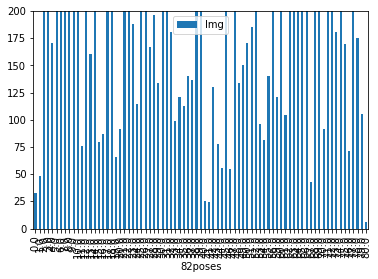

In [96]:
group_82=kp_processed_files.groupby(['82poses']).count()[['Img']].plot(kind='bar',ylim=[0,200])

##### 3. 계층구조 확인
- 3레벨의 계층구조 확인

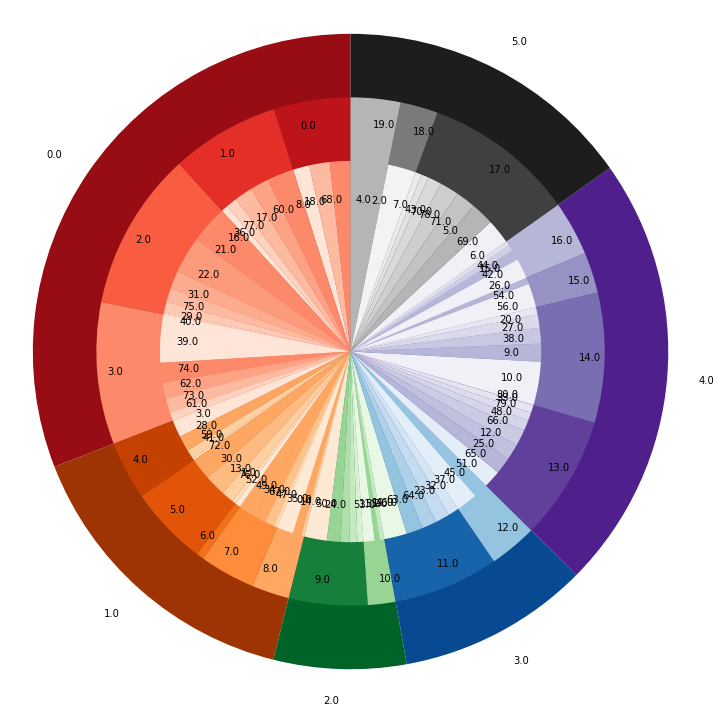

In [89]:
#빈도수를 분포로 나타내기
plt.figure(figsize=(10,10))
labels_6 = kp_processed_files[['6poses','Img']].groupby(['6poses']).count().index
sizes_6 = kp_processed_files[['6poses','Img']].groupby(['6poses']).count().values.flatten()
labels_20 = kp_processed_files[['20poses','Img']].groupby(['20poses']).count().index
sizes_20=kp_processed_files[['20poses','Img']].groupby(['20poses']).count().values.flatten()
labels_82 =kp_processed_files.groupby(['6poses','20poses','82poses']).count().sort_values( by=['6poses','20poses','Folder'],ascending=[True,True,False]).index.get_level_values('82poses')
sizes_82=kp_processed_files.groupby(['6poses','20poses','82poses']).count().sort_values( by=['6poses','20poses','Folder'],ascending=[True,True,False])[['Img']].values.flatten()

cmap1 = plt.cm.Reds
cmap2 = plt.cm.Oranges
cmap3 = plt.cm.Greens
cmap4 = plt.cm.Blues
cmap5 = plt.cm.Purples
cmap6 = plt.cm.Greys

outer_colors = [cmap1(.9), cmap2(.9), cmap3(.9),cmap4(.9), cmap5(.9), cmap6(.9)]
inner_colors = [*cmap1(np.linspace(.8, .4, 4)),
                *cmap2(np.linspace(.8, .4, 5)),
                *cmap3(np.linspace(.8, .4, 2)),
                *cmap4(np.linspace(.8, .4, 2)),
                *cmap5(np.linspace(.8, .4, 4)),
                *cmap6(np.linspace(.8, .4, 3))]

center_colors = [*cmap1(np.linspace(.4, .1, 3)),
                *cmap1(np.linspace(.4, .1, 5)),
                *cmap1(np.linspace(.4, .1, 7)),
                *cmap1(np.linspace(.4, .1, 5)),
                *cmap2(np.linspace(.4, .1, 3)),
                *cmap2(np.linspace(.4, .1, 5)),
                *cmap2(np.linspace(.4, .1, 1)),
                *cmap2(np.linspace(.4, .1, 4)),
                *cmap2(np.linspace(.4, .1, 3)),
                *cmap3(np.linspace(.4, .1, 5)),
                *cmap3(np.linspace(.4, .1, 3)),
                *cmap4(np.linspace(.4, .1, 5)),
                *cmap4(np.linspace(.4, .1, 2)),
                 
                *cmap5(np.linspace(.4, .1, 8)),
                *cmap5(np.linspace(.4, .1, 5)),
                *cmap5(np.linspace(.4, .1, 2)),
                *cmap5(np.linspace(.4, .1, 4)),

                *cmap6(np.linspace(.4, .1, 7)),
                *cmap6(np.linspace(.4, .1, 1)),

                *cmap6(np.linspace(.4, .1, 2))]

outer = plt.pie(sizes_6, labels=labels_6,colors=outer_colors,
                 startangle=90, frame=True)
nested = plt.pie(sizes_20, labels=labels_20, 
                 radius=0.8,colors=inner_colors,
                  startangle=90, labeldistance=.9)
centre = plt.pie(sizes_82, labels=labels_82, 
                 radius=0.6,colors=center_colors,
                  startangle=90, labeldistance=0.8)
fig = plt.gcf()
        
plt.axis('equal')
plt.tight_layout()

plt.show()

In [102]:
kp_processed_files.groupby(['6 poses','20poses','82poses']).count()\
.sort_values( by=['6 poses','20poses','Folder'],ascending=[True,True,False])

Folder  Img  6poses
6 poses 20poses 82poses                     
누워서     13.0    65.0        221  221     221
                25.0        207  207     207
                12.0        205  205     205
                66.0        200  200     200
                48.0        134  134     134
...                         ...  ...     ...
팔       11.0    23.0        188  188     188
                32.0        181  181     181
                37.0        137  137     137
        12.0    45.0        268  268     268
                51.0        185  185     185

[79 rows x 3 columns]

In [65]:
processed_fiels.groupby(['6poses','Folder']).count()['Img'].to_csv('yoga_ref.csv')

hierarchical_table=kp_processed_files[['6poses','20poses','82poses','Img']]\
.groupby(['6poses','20poses','82poses']).count()\
.sort_values(by=['6poses','20poses','82poses'],ascending=False)

hierarchical_table.to_csv('imbalanced_datasets.csv')
hierarchical_table

Img
6poses 20poses 82poses     
5.0    19.0    4.0      171
               2.0      301
       18.0    7.0      356
       17.0    71.0     241
               70.0      92
...                     ...
0.0    1.0     17.0     239
               16.0      87
       0.0     68.0     260
               18.0     258
               8.0      209

[77 rows x 1 columns]

In [90]:
# 생략되어  해당 최하위 레벨의 포즈 인덱스 순서대로 정렬
kp_processed_files.groupby(['6poses','20poses','82poses']).count()\
.index.get_level_values('82poses')

Float64Index([ 8.0, 18.0, 68.0, 16.0, 17.0, 36.0, 60.0, 77.0, 21.0, 22.0, 29.0,
              31.0, 40.0, 75.0, 39.0, 61.0, 62.0, 73.0, 74.0,  3.0, 28.0, 41.0,
              59.0,  1.0, 13.0, 30.0, 72.0, 76.0, 34.0, 49.0, 52.0, 67.0,  0.0,
              35.0, 47.0, 11.0, 14.0, 24.0, 50.0, 53.0, 19.0, 46.0, 55.0, 23.0,
              32.0, 37.0, 63.0, 64.0, 45.0, 51.0, 12.0, 25.0, 33.0, 48.0, 65.0,
              66.0, 79.0, 80.0,  9.0, 10.0, 20.0, 27.0, 38.0, 54.0, 56.0, 15.0,
              26.0, 42.0, 44.0,  5.0,  6.0, 43.0, 69.0, 70.0, 71.0, 78.0,  7.0,
               2.0,  4.0],
             dtype='float64', name='82poses')

In [101]:
#각 값
kp_processed_files.groupby(['6poses','20poses','82poses']).count()\
[['Img']].values.flatten()

array([209, 258, 260,  87, 239, 140, 336, 228, 477, 466, 134, 233,  25,
       170, 607, 104, 200, 181, 255, 218, 196,  24, 121,  48, 161, 264,
       276,  71, 121, 150, 214,  43,  33, 113, 211,  76, 287, 115, 171,
        96,  66,  55, 140, 188, 181, 137, 288, 207, 268, 185, 205, 207,
        99, 134, 221, 200, 105,   6, 226, 546,  92, 167, 200,  81, 305,
        80, 252, 130,  56, 250, 310,  78, 293,  92, 241, 175, 356, 301,
       171])

##### 4. 이미지 사이즈 확인 
- 산점도와 버블플랏, 히스토그램으로 이미지 사이즈 확인
- height, width 특정 비율인 값들이 많음 (산점도에서 선으로 이어져서 나옴)
- 다양한 사이즈가 있으나 이미지가 대체적으로 크진 않고 가로가 긴 편이 많다
- 웹캠 사이즈나 모델 인퍼런스에 들어가는 이미지 사이즈 고려하면 좋다.


In [103]:
def get_dims(file):
    '''이미지의 가로,세로 구하기'''
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

filepath = '/content/drive/MyDrive/ai_trainer/kp_processed/'
height=[];width=[]
filelist = [filepath + f for f in os.listdir(filepath)[:81]]
for files in filelist:
  imglist=[files +'/'+ f for f in os.listdir(files)]
  for img in imglist:
    try:
      h,w=get_dims(img)
      height.append(h)
      width.append(w)
    except(AttributeError):
      pass

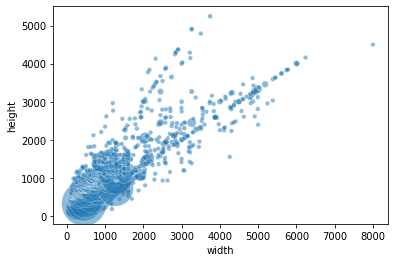

In [104]:
total_dim_df=pd.DataFrame({'height' : height,'width':width})

sizes = total_dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'}) 
sns.scatterplot(data=sizes, x="width", y="height", size="count", 
                legend=False, sizes=(20, 2000),alpha=0.5)

In [105]:
def draw_line32(x):
  ''' 이미지 비율 확인용'''
  return 3/2*x
def draw_line34(x):
  ''' 이미지 비율 확인용'''
  return 3/4*x
def draw_line58(x):
  ''' 이미지 비율 확인용'''
  return 5/8*x

((0.0, 9000.0), (0.0, 6000.0))

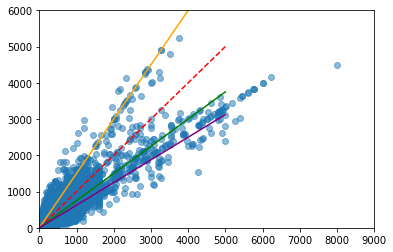

In [106]:
plt.scatter(x=sizes.width, y=sizes.height,alpha=0.5) 
plt.plot(range(5000),range(5000),'r--') #1:1 ration
plt.plot(range(5000),[draw_line32(x) for x in range(5000)],color='orange')
plt.plot(range(5000),[draw_line34(x) for x in range(5000)],color='green',)
plt.plot(range(5000),[draw_line58(x) for x in range(5000)],color='purple',)

plt.xlim(0, 9000), plt.ylim(0, 6000)


(array([6.500e+01, 3.160e+02, 7.710e+02, 1.024e+03, 1.344e+03, 2.511e+03,
        1.104e+03, 1.257e+03, 1.409e+03, 7.240e+02, 6.860e+02, 5.400e+02,
        6.480e+02, 3.490e+02, 2.440e+02, 1.240e+02, 1.810e+02, 6.400e+02,
        2.410e+02, 2.050e+02, 1.820e+02, 5.300e+01, 1.060e+02, 3.300e+01,
        1.290e+02, 1.870e+02, 2.800e+01, 2.900e+01, 2.400e+01, 1.120e+02,
        1.000e+01, 1.700e+01, 1.000e+01, 1.000e+01, 1.300e+01, 1.600e+01,
        1.600e+01, 1.100e+01, 3.900e+01, 1.800e+01, 5.000e+00, 5.000e+00,
        6.000e+00, 1.100e+01, 6.000e+00, 9.000e+00, 3.300e+01, 1.000e+00,
        2.000e+01, 5.000e+00, 1.000e+00, 6.000e+00, 7.000e+00, 1.100e+01,
        2.000e+00, 3.000e+00, 2.800e+01, 4.000e+00, 6.000e+00, 4.000e+00,
        7.000e+00, 3.100e+01, 0.000e+00, 1.800e+01, 2.000e+00, 9.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 0.000e+00,
        2.000e+00, 1.000e+00, 1.000e+0

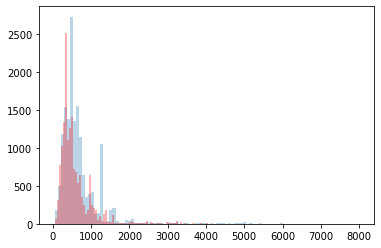

In [109]:
plt.hist(total_dim_df.width,bins=100,alpha=0.3)
plt.hist(total_dim_df.height,bins=100,alpha=0.3, color='r')